# 01. 데이터 수집

### 1) 정보 찾기

Open API 인증을 요청했지만 아직 승인 받지 못함    

  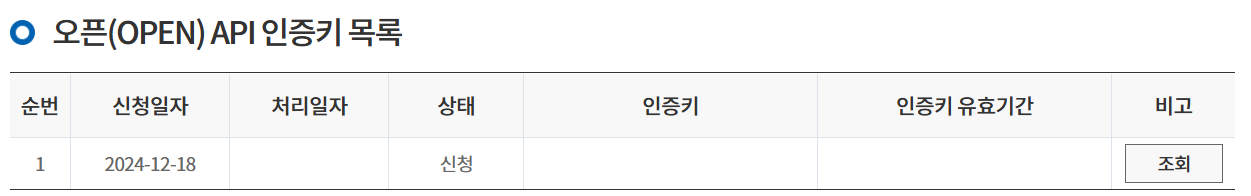

온통청년 (https://www.youthcenter.go.kr/youngPlcyUnif/youngPlcyUnifList.do) 크롤링 하기로 결정

### 2) 크롤링

**라이브러리 불러오기**

In [1]:
import requests
from bs4 import BeautifulSoup as bs
import re
import pickle
import json
import os

**json,pickle 저장 및 불러오기 함수 정의**

In [2]:
def save_pickle(path: str, file_name: str, data: list):
    """
    데이터를 pickle 파일로 저장.
    """
    os.makedirs(path, exist_ok=True)
    with open(f"{path}/{file_name}", "wb") as f:
        pickle.dump(data, f)

def load_pickle(path: str) -> list:
    """
    pickle 파일에서 데이터 불러오기.
    """
    with open(path, "rb") as f:
        return pickle.load(f)

def save_json(path: str, file_name: str, data: list):
    """
    데이터를 json 파일로 저장.
    """
    os.makedirs(path, exist_ok=True)
    with open(f"{path}/{file_name}", "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4, ensure_ascii=False)

def load_json(path: str) -> list:
    """
    json 파일에서 데이터 불러오기.
    """
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)


**정책 ID 크롤링**
- 목록 정렬: 1 페이지 - 60개 정책, 총 59 페이지.
- 정책 모집 현황은 '진행중','상시','신청 마감'으로 3가지. `24년 12월 23일 기준`으로 `상시`, `진행중`인 정책들만 추출.
   ```
    <div class="badge">
      <span class="label green">진행중</span>
      <span class="cate">주거분야</span>
    </div>
    ```
- 각 정책의 링크가 아래와 같이 구성. id 부분에서 `dtlLink_`를 제외한 부분이 각 정책의 코드번호.
  ```
   <a href="#"id="dtlLink_R2024011018628"onclick="f_Detail('R2024011018628');"class="tit">청년 주택드림 청약통장</a>
   ```
- 1 페이지부터 59 페이지까지 각 페이지에 있는 정책들의 id만 list로 추출.


In [3]:
def get_ids_with_state(page_num: int, url: str) -> list:
    """
    청년 정책의 ID 수집.
    Parameters:
        page_num (int): 추출하려는 총 페이지 수
        url (str): 추출 대상의 페이지 링크를 조합할 베이스 링크
    Returns:
        policy_id_list (list): 상시, 진행중인 정책의 ID를 list로 모아 반환합니다.
    """
    policy_id_list = []
    for i in range(1, page_num + 1):
        response = requests.get(f"{url}{i}")
        soup = bs(response.text, "lxml")
        
        badges = soup.select("div.badge")
        titles = soup.select("a.tit")
        organ = soup.select("div.organ-name")
        
        for j in range(len(titles)):
            badge = badges[j].find("span", attrs={"label"}).text
            if badge in ["진행중", "상시"]:
                policy_id = titles[j].attrs["id"].replace("dtlLink_", "")
                organ_name = re.sub(r"<.*?>", "", str(organ[j].select_one("p")))
                organ_name = "세종" if organ_name == "세종 세종" else organ_name
                if policy_id not in policy_id_list:
                    policy_id_list.append([policy_id, organ_name])
    
    return policy_id_list


**정책 상세 정보 크롤링**
- index

| index | name               | index | name                     |
| ----- | ------------------ | ----- | ------------------------ |
| 0     | "정책 번호"        | 13    | "추가 단서 사항"         |
| 1     | "정책 분야"        | 14    | "참여 제한 대상"         |
| 2     | "지원 내용"        | 15    | "신청 절차"              |
| 3     | "사업 운영 기간"   | 16    | "심사 및 발표"           |
| 4     | "사업 신청청 기간" | 17    | "신청 사이트"            |
| 5     | "지원 규모(명)"    | 18    | "제출 서류"              |
| 6     | "비고"             | 19    | "기타 유익 정보"         |
| 7     | "연령"             | 20    | "주관 기관"              |
| 8     | "거주지 및 소득"   | 21    | "운영 기관"              |
| 9     | "학력"             | 22    | "사업관련 참고 사이트 1" |
| 10    | "전공"             | 23    | "사업관련 참고 사이트 2" |
| 11    | "취업 상태"        | 24    | "첨부파일"               |
| 12    | "특화 분야"        |


**HTML 문자열 처리 함수 정의**
- '객체.text'로 추출되지 않는 요소들이 존재. -> '객체.contents'로 개별 요소 추출.
- 요소에 `<br/>`이 있는 경우 이 현상이 잘 나타남. -> `<br/>`태그 제거
- '객체.text'로 추출한 경우 과도한 공백 및 줄바꿈 발견
- '객체.contents'로 추출할 경우 과도한 공백 및 줄바꿈을 이스케이프 문자로 추출 -> `\n, \t`등 이스케이프 문자 제거
- 여기서 과도한 공백이란 두 칸 이상의 띄어쓰기를 한 경우. 전체 띄어쓰기를 한 칸으로 맞추려면 시간이 오래 소요되기 때문에 두 칸만 제거.

In [4]:
def formated(string: str) -> str:
    """
    HTML 태그, 이스케이프 문자, 과도한 공백 제거.
    """
    tag_format = r"<.*?>"
    string = string.replace("\n", "").replace("\t", "")
    string = re.sub(tag_format, "", str(string))
    string = string.replace("  ", "")
    return string

In [5]:
def crawling(policy_id_list: list, url: str, params: dict, cont_attrs: bool = True) -> list:
    """
    정책 상세 정보를 수집.
    """
    total_policy = []
    format = {"br": r"<br/>", "a": r"<a href"}
    
    for id, organ in policy_id_list:
        policy = {}
        try:
            response = requests.get(f"{url}{id}")
        except:
            response = requests.get(f"{url.replace('https', 'http')}{id}")
        
        soup = bs(response.text, "html.parser")

        # 정책 이름 추출
        title = soup.find(params["title"][0], params["title"][1]).text
        policy["정책 이름"] = title
        
        if cont_attrs:
            policy["기관"] = organ
            subtitle = soup.find("p", "doc_desc").text
            subtitle = subtitle.replace("\r", " ")
            subtitle = subtitle.strip()
            policy["요약"] = subtitle
            list_tit = soup.find_all(
                name=params["list_tit"][0], attrs=params["list_tit"][1]
            )
            list_cont = soup.find_all(
                name=params["list_cont"][0], attrs=params["list_cont"][1]
            )
        else:
            list_tit = soup.find_all(name=params["list_tit"][0])
            list_cont = soup.find_all(name=params["list_cont"][0])
        
        # 항목 내용 처리
        for i in range(len(list_tit)):
            # list_cont[i].contents = ["\n", "ㅁㅁㅁ", "\n"] 또는 ["\n\t\t\t\tㅁㅁㅁㅁ\n\t\t\t\t", "<br/>", "ㅁㅁㅁ"]과 같이 나옴
            if len(list_cont[i].contents) > 1:
                contents = []
                for j in range(len(list_cont[i].contents)):
                    content = list_cont[i].contents[j]
                    # <br/> 제거
                    if re.match(format["br"], str(content)) != None:
                        content = None
                    # url만 있는 경우 추출
                    elif re.match(format["a"], str(content)) != None:
                        content = content.attrs["href"]
                    # 그 외 공백 제거, '\n', '\t', 제거 안된 html 태그 제거
                    else:
                        content = content.text
                        content = content.strip()
                        content = formated(content)
                    # 처리 작업이 끝난 후 의미있는 요소만 contents(list)에 추가
                    if content not in [None, "\n", "", ","]:
                        # \r이 있을 경우 이를 구분자로 분할한 뒤 삽입
                        if "\r" in content:
                            content = content.split("\r")
                            for con in content:
                                contents.append(con)
                        else:
                            contents.append(content)
                if len(contents) == 1:
                    contents = "".join(contents)
            else:
                contents = list_cont[i].contents
                contents = "".join(contents)
                contents = formated(contents)

            # 동일한 요소가 contents(list)에 들어있을 경우
            if (
                isinstance(contents, list)
                and len(contents) == 2
                and contents[0] == contents[1]
            ):
                contents = set(contents)
                contents = "".join(contents)
                contents = formated(contents)
            # 정책의 항목 이름, 내용 연결
            policy[list_tit[i].text] = contents
        total_policy.append(policy)
    return total_policy

**main 코드**
- 해당 웹 사이트 크롤링

In [ ]:
# 저장 경로 생성
DATA_DIR = "../data"
os.makedirs(DATA_DIR, exist_ok=True)

# 정책 ID 수집
URL = "https://www.youthcenter.go.kr/youngPlcyUnif/youngPlcyUnifList.do?pageUnit=60&pageIndex="
policy_id_list = get_ids_with_state(59, URL)
print(f"{len(policy_id_list)}개 정책 ID 크롤링 완료")

# 저장
save_pickle(f"{DATA_DIR}", "policy_id_list.pkl", policy_id_list)
print("policy_id_list 저장 완료")

# 정책 상세 정보 크롤링
DETAIL_URL = "https://www.youthcenter.go.kr/youngPlcyUnif/youngPlcyUnifDtl.do?bizId="
params = {
    "title": ["h2", "doc_tit01 type2"],
    "list_tit": ["div", "list_tit"],
    "list_cont": ["div", "list_cont"],
}
total_policy = crawling(policy_id_list, DETAIL_URL, params, cont_attrs=True)
print(f"{len(total_policy)}개 정책 상세 정보 크롤링 완료")

# 저장
save_json(f"{DATA_DIR}", "policy.json", total_policy)
print("policy.json 저장 완료")


1337개 정책 ID 크롤링 완료
policy_id_list 저장 완료


# 02. 데이터 전처리

### 1) 데이터 구조화

**사용되지 않을 항목 삭제**
- key값이 아래에 해당하면 항목 삭제
  >["정책 번호", "신청 사이트", "사업관련 참고 사이트 1", "사업관련 참고 사이트 2", "첨부파일"]


**의미 없는 값 삭제**
- value값이 아래에 해당하면 항목 삭제
  >["제한없음", "", "-", "상관없음", "□제한없음","□ 제한없음","- 제한없음","-제한없음"]

In [6]:
# 삭제 항목 정의
remove_keys = [
    "정책 번호", "신청 사이트", 
    "사업관련 참고 사이트 1", "사업관련 참고 사이트 2", "첨부파일"
]

remove_values = [
    "제한없음", "", "-", "상관없음", "□제한없음",
    "□ 제한없음","- 제한없음","-제한없음"
]

# 삭제 함수 정의
def remove_keys_from_data(data, keys):
    if isinstance(data, list):
        return [remove_keys_from_data(item, keys) for item in data]
    elif isinstance(data, dict):
        return {
            key: remove_keys_from_data(value, keys)
            for key, value in data.items()
            if key not in keys
        }
    else:
        return data

def remove_values_from_data(data):
    if isinstance(data, list):
        return [remove_values_from_data(item) for item in data if item not in remove_values]
    elif isinstance(data, dict):
        return {
            key: remove_values_from_data(value)
            for key, value in data.items()
            if value not in remove_values
        }
    else:
        return data
    
# 불러오기 
data = load_json("../data/policy.json")

# 삭제
data_cleaned_keys = remove_keys_from_data(data, remove_keys)
preprocess_data = remove_values_from_data(data_cleaned_keys)

# 저장
save_json("../data","policy_result.json", preprocess_data)

print("policy_result.json 저장 완료")

policy_result.json 저장 완료


### 2) 텍스트 전처리

**불용어 삭제**
- 문서에서 `100번 이상` 등장한 단어를 frequent_words 리스트에 저장
- 리스트에서 불용어로 판단 되는 것들 추출
- 성능 평가 후 성능 최적화를 위해 삭제하는 단어를 변경할 수 있음
- 불용어 리스트
  > "수행", "경우", "해당", "통하여", "대한", "관련","등", "및", "또는", "중인", "통해",
    "따라", "서비스", "제공", "프로그램", "참여", "따른", "대한", "해당", "관한","이용", 
    "등을", "두고"


In [7]:
import json
import re
from collections import Counter

# 불러오기
data = load_json("../data/policy.json")

# 모든 텍스트 추출
def text_from_json(data):
    """
    JSON 데이터에서 모든 문자열을 추출.
    """
    texts = []
    if isinstance(data, dict):
        for value in data.values():
            texts.extend(text_from_json(value))
    elif isinstance(data, list):
        for item in data:
            texts.extend(text_from_json(item))
    elif isinstance(data, str):
        texts.append(data)
    return texts

# 단어 분리
def text_to_word(text):
    """
    텍스트를 정제하고 단어 단위로 분리.
    """
    text = re.sub(r'[^가-힣a-zA-Z0-9\s]', '', text)  # 특수문자 제거
    words = text.split()  # 공백 기준으로 단어 분리
    return words

# 자주 등장하는 단어 찾기
def get_frequent_words(words, threshold=100):
    """
    단어 목록에서 자주 등장하는 단어를 찾음.
    """
    word_counts = Counter(words)
    frequent_words = [word for word, count in word_counts.items() if count >= threshold]
    return frequent_words

# 실행
if __name__ == "__main__":

    # 불러오기
    FILE_PATH = "../data/policy_result.json"
    data = load_json(FILE_PATH)
    
    # 텍스트 추출
    texts = text_from_json(data)
    
    # 단어 분리
    all_words = []
    for text in texts:
        all_words.extend(text_to_word(text))
    
    # 50번 이상 등장하는 단어
    threshold = 100
    frequent_words = get_frequent_words(all_words, threshold)
    
    # 출력
    print("[100번 이상 등장하는 단어]")
    for i in range(0, len(frequent_words), 10):
        print(", ".join(frequent_words[i:i + 10]))


[100번 이상 등장하는 단어]
청년, 청년의, 내, 위해, 지원, 주거분야, 최대, 연, 있는, 자
기준, 월, 경우, 연계, 1년, 이상, 가입, 시, 이하, 주택
출산, 2024년, 12월31일, 가능, 만, 19세, 34세, 소득, 대상, 월세
매월, 2024, 2, 신청, 무주택, 중위소득, 등, 및, 확인, 제외
포함, 거주, 별도, 또는, 중인, 후, 온라인, 방문, 지급, 신청서
서류, 사본, 사업, 심사, 통해, 고용노동부, 위한, 일자리분야, 1, 따라
서비스, 제공, 기간, 프로그램, 참여, 취업, 따른, 단, 1회, 추가
상시, 중, 수, 6개월, 이내, 필요한, 1인, 가구, 문의, 대상자
동의서, 제출, 신청인이, 관련, 증빙서류, 3, 4, 5, 3개월, 보건복지부
지역, 복지문화분야, 맞춤형, 부담, 참고, 대한, 모두, 해당, 배우자, 현재
관한, 홈페이지, 관할, 선정, 기타, 주민등록상, 동일, 중소기업, 이용, 불가
그, 신분증, 주민등록등본, 창업, 지원내용, 대상으로, 필수, 등을, 1인당, 미만
각, 개별, 지원사업, 18세, 이후, 39세, 공고문, 20241231, 본인, 주소지
거주지, 읍면동, 행정복지센터, 예산, 미취업, 안내, 참조, 무료, 발급, 기업
모집, 서울, 운영, 교육, 서울시, 신혼부부, 신청자, 작성, 접수, 내용
주관기관과, 12, 도내, 상담, 자립준비청년, 신청일, 두고, 신청방법, 지원대상, 거주하는
임차인, 교육분야, 30만원, 사업장, 사업자, 소상공인, 청년들의, 통한, 지원금, 면접
소재, 사업기간, 참여자, 일자리, 11, 대학생, 미정, 경기, 경기도, 공고
관내, 이메일, 경북, 경남, 컨설팅, 1부, 북구, 동구, 남구, 울산광역시
전세보증금반환보증, 보증료, 울산


**url 삭제**
- 정규표현식이 'http://'(http,https),'.kr'인 경우 url이라고 판단하고 삭제  

**특수기호 삭제**
- 숫자, 한글, 영어를 제외하고 삭제
- 소수점 유지를 위해 '.'은 유지

In [8]:
import re

# 불러오기
data = load_json("../data/policy_result.json")

# 불용어 
stopwords = [
    "수행", "경우", "해당", "통하여", "대한", "관련","등", "및", "또는", "중인", "통해",
    "따라", "서비스", "제공", "프로그램", "참여", "따른", "대한", "해당", "관한","이용", 
    "등을", "두고"
]

# 제거 함수
def remove_text(text):
    if isinstance(text, str):
        # URL 제거
        text = re.sub(r'\bhttps?://[^\s]*\.kr\b', '', text)
        
        # 특수기호 제거 (숫자, 한글, 영어 유지)
        text = re.sub(r'[^가-힣a-zA-Z0-9\s.~%]',' ', text)
        
        # 불용어 제거
        for stopword in stopwords:
            text = text.replace(stopword, '')
        return text   
    
    return text

# 데이터 처리
def process_json(data):
    if isinstance(data, dict):
        return {key: process_json(value) for key, value in data.items()}
    elif isinstance(data, list):
        return [process_json(item) for item in data]
    elif isinstance(data, str):
        return remove_text(data)
    else:
        return data


cleaned_data = process_json(data)

# 저장
save_json("../data","policy_result.json",cleaned_data)
print("policy_result.json 저장 완료")

policy_result.json 저장 완료


### 3) 토큰화

**key- value값 병합**
- key 값:'정책 이름', '기관', '요약', '정책 분야'인 경우는 유지
- 나머지 모든 key,value값 문자열로 반환 -> 병합 후 key 값:"내용"의 value값에 저장

**토큰화**
- 청년 정책 챗봇은 정확한 정보 전달을 최우선으로 여김
- chunk size를 지정해 토큰화하지 않고 key-value값 병합된 문자열을 하나의 토큰으로 나눔

In [9]:
import json
import re

# 불러오기
data = load_json("../data/policy_result.json")

# 문자열 병합 
def merge_values(item):
    """
    리스트, 딕셔너리, 문자열을 하나의 문자열로 병합
    """
    if isinstance(item, list):
        return " ".join(merge_values(sub_item) for sub_item in item)
    elif isinstance(item, dict):
        return " ".join(f"{key}: {merge_values(value)}" for key, value in item.items())
    elif isinstance(item, str):
        return item.strip()
    else:
        return str(item)


# 특정 키는 유지, 나머지는 병합
def restructure_policy_data(data):
    """
    '정책 이름', '기관', '요약', '정책 분야'는 유지하고 나머지는 '내용'에 병합
    """
    result = []
    if isinstance(data, list):
        for item in data:
            if isinstance(item, dict):
                policy = {
                    "정책 이름": item.get("정책 이름", "알 수 없음"),
                    "기관": item.get("기관", "알 수 없음"),
                    "요약": item.get("요약", "알 수 없음"),
                    "정책 분야": item.get("정책 분야", "알 수 없음")
                }

                # '내용'에 나머지 항목 병합
                remaining_content = [
                    f"{key}: {merge_values(value)}"
                    for key, value in item.items()
                    if key not in ["정책 이름", "기관", "요약", "정책 분야"]
                ]
                policy["내용"] = " ".join(remaining_content)

                result.append(policy)
    return result


# 실행행
restructured_data = restructure_policy_data(data)


# 저장
save_json("../data", "policy_result.json", restructured_data)
print("policy_result.json 저장 완료")



policy_result.json 저장 완료


### 4) 추가 수정
성능 평가 후 개선되면 좋겠다고 판단하여 추가적으로 처리

**기관->지역**
- 기관에 지역명이 포함되어 있어 지역 구분 용으로 사용 ex) "기관": "인천 계양구"
- 지역을 잘 구분하지 못하고 답을 보내 더 명확하게 구분하고자 다음과 같이 변경
>   r'경.*북.*': '경상북도',   
    r'경.*남.*': '경상남도',   
    r'강.*원.*': '강원도',   
    r'전.*북.*': '전라북도',   
    r'전.*남.*': '전라남도',   
    r'충.*북.*': '충청북도',   
    r'충.*남.*': '충청남도',   
    r'제.*주.*': '제주특별자치도',   
    r'서.*울.*': '서울특별시',   
    r'부.*산.*': '부산광역시',   
    r'대.*구.*': '대구광역시',   
    r'대.*전.*': '대전광역시',   
    r'광.*주.*': '광주광역시',   
    r'울.*산.*': '울산광역시',   
    r'인.*천.*': '인천광역시',   
    r'세.*종.*': '세종특별자치시'   

- 지역명이 없는 기관은 전국 대상으로 처리 ex) "기관": "고용노동부"

In [10]:
import json
import re

# 불러오기
data = load_json("../data/policy_result.json")

# 지역 매핑 (정규표현식: 기관명에 포함된 지역명)
region_patterns = {
    r'경.*북.*': '경상북도',
    r'경.*남.*': '경상남도',
    r'강.*원.*': '강원도',
    r'전.*북.*': '전라북도',
    r'전.*남.*': '전라남도',
    r'충.*북.*': '충청북도',
    r'충.*남.*': '충청남도',
    r'제.*주.*': '제주특별자치도',
    r'서.*울.*': '서울특별시',
    r'부.*산.*': '부산광역시',
    r'대.*구.*': '대구광역시',
    r'대.*전.*': '대전광역시',
    r'광.*주.*': '광주광역시',
    r'울.*산.*': '울산광역시',
    r'인.*천.*': '인천광역시',
    r'세.*종.*': '세종특별자치시'
}

# 데이터 변환
def replace_institution_with_region(data):
    """
    '기관'을 '지역'으로 키를 대체하고 순서를 유지합니다.
    """
    for policy in data:
        if "기관" in policy:
            institution = policy["기관"]
            region = '전국'  # 기본값 설정
            
            # 기관명에서 지역 매칭
            for pattern, mapped_region in region_patterns.items():
                if re.search(pattern, institution):
                    region = mapped_region
                    break
            
            # '기관'을 '지역'으로 대체 (순서 유지)
            updated_policy = {}
            for key, value in policy.items():
                if key == "기관":
                    updated_policy["지역"] = region
                else:
                    updated_policy[key] = value
            
            # 기존 항목을 새로운 항목으로 교체
            policy.clear()
            policy.update(updated_policy)

# 실행행
replace_institution_with_region(data)

# 저장
save_json("../data", "policy_result.json", data)
print("policy_result.json 저장 완료")


policy_result.json 저장 완료


**key값 띄어쓰기 삭제**
- key값의 띄어쓰기 때문에 인식에 헷갈림이 있어 보임
- '운영 기관'보다 '운영기관'을 더 잘 인식   

**'분야' 삭제**
- key 값 '정책 분야'의 내용에 담긴 마지막 두 글자 '분야' 삭제 
    - ex) 일자리분야 -> 일자리
- 더 다양한 질문에서 잘 인식
    - ex) 일자리에 고민이 있어.

In [11]:
# 불러오기
data = load_json("../data/policy_result.json")

# 띄어쓰기 제거 
def remove_spaces(data):
    """
    모든 Key에서 띄어쓰기를 제거합니다.
    """
    if isinstance(data, list):
        return [remove_spaces(item) for item in data]
    elif isinstance(data, dict):
        return {key.replace(" ", ""): remove_spaces(value) for key, value in data.items()}
    else:
        return data

# 마지막 2글자 삭제 
def modify_policy_field(data):
    """
    "정책분야"의 Value 마지막 2글자를 삭제합니다.
    """
    if isinstance(data, list):
        for item in data:
            modify_policy_field(item)
    elif isinstance(data, dict):
        if "정책분야" in data and isinstance(data["정책분야"], str):
            data["정책분야"] = data["정책분야"][:-2]  # 마지막 2글자 제거
        for key, value in data.items():
            modify_policy_field(value)

# 실행
data = remove_spaces(data)
modify_policy_field(data)

# 저장
save_json("../data", "policy_result.json", data)
print("policy_result.json 저장 완료")


policy_result.json 저장 완료


# 03. RAG 시스템

### 1) 환경 설정

**.env 파일**
- API키 저장한 .env 파일 불러오기

In [12]:
from dotenv import load_dotenv
load_dotenv()

True

**라이브러리 불러오기**

In [13]:
import os
import json
import pickle
import shutil
import re

from langchain_community.document_loaders import TextLoader
from langchain.document_loaders import PyPDFLoader
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain.schema import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables.history import RunnableWithMessageHistory, RunnableLambda
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.cache import SQLiteCache
from langchain.memory import ConversationBufferMemory
from operator import itemgetter
from langchain_community.tools import TavilySearchResults

from langchain_core.tools import tool
from itertools import chain

### 2) Vector Store 생성 및 저장

In [14]:
import os
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.schema import Document
import json

# 설정
DIRECTORY_PATH = r'..\data'
PERSIST_DIRECTORY = r'..\data\vector_store\policy'
COLLECTION_NAME = "policy"
EMBEDDING_MODEL_NAME = 'text-embedding-ada-002'
TOKENIZED_DATA_PATH = os.path.join(DIRECTORY_PATH, 'policy_result.json')

# 임베딩 모델 초기화
embedding_model = OpenAIEmbeddings(model=EMBEDDING_MODEL_NAME)

# 불러오기
data = load_json(TOKENIZED_DATA_PATH)

# Document 객체로 변환
documents = []
for item in data:
    policy_name = item.get("정책이름", "")
    summary = item.get("요약", "")
    policy_field = item.get("정책분야", "")
    region = item.get("지역", "")
    content = item.get("내용", "")
    
    merged_text = f"{policy_name} {summary} {policy_field} {region} {content}"       
    documents.append(
        Document(
            page_content=merged_text,
            metadata={
                "정책이름": policy_name,
                "요약": summary,
                "정책분야": policy_field,
                "내용": content,
                "지역": region,
                "source": TOKENIZED_DATA_PATH
            }
        )
    )

# Vector Store 생성/로드
if os.path.exists(PERSIST_DIRECTORY):
    print(f"기존 Vector Store를 {PERSIST_DIRECTORY}에서 로드합니다.")
    vector_store = Chroma(
        persist_directory=PERSIST_DIRECTORY,
        collection_name=COLLECTION_NAME,
        embedding_function=embedding_model
    )
else:
    print(f"새로운 Vector Store를 {PERSIST_DIRECTORY}에 생성합니다.")
    os.makedirs(PERSIST_DIRECTORY, exist_ok=True)
    vector_store = Chroma.from_documents(
        documents=documents,
        embedding=embedding_model,
        collection_name=COLLECTION_NAME,
        persist_directory=PERSIST_DIRECTORY
    )

# Vector Store 저장
vector_store.persist()
print(f"Vector Store 저장 완료")

# 저장된 파일 확인
saved_files = os.listdir(PERSIST_DIRECTORY)
print(f"저장된 파일 목록: {saved_files}")

C:\Users\User\AppData\Local\Temp\ipykernel_18672\296073155.py:15: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding_model = OpenAIEmbeddings(model=EMBEDDING_MODEL_NAME)


기존 Vector Store를 ..\data\vector_store\policy에서 로드합니다.
Vector Store 저장 완료


C:\Users\User\AppData\Local\Temp\ipykernel_18672\296073155.py:47: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vector_store = Chroma(
C:\Users\User\AppData\Local\Temp\ipykernel_18672\296073155.py:63: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vector_store.persist()


저장된 파일 목록: ['07237f56-5751-418f-a94c-8b3e346c8617', 'chroma.sqlite3']


### 3) 질문 - 답변 생성

**라이브러리 불러오기**   


In [21]:
!pip install onnxruntime ragas

  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.47.0 requires tokenizers<0.22,>=0.21, but you have tokenizers 0.20.3 which is incompatible.


In [15]:
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.prompts import PromptTemplate, MessagesPlaceholder, ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser,StrOutputParser
from langchain.memory import ConversationBufferMemory

from langchain.chains import LLMChain
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.documents import Document
from langchain_community.tools import TavilySearchResults
from langchain_core.runnables.history import RunnableWithMessageHistory, RunnableLambda

from ragas import EvaluationDataset, RunConfig, evaluate
from ragas.metrics import (
    LLMContextRecall, Faithfulness, LLMContextPrecisionWithReference, AnswerRelevancy
)
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper

from pydantic import BaseModel, Field

from textwrap import dedent
from operator import itemgetter
from pprint import pprint
import json
import random
import re

from langchain_core.tools import tool
from itertools import chain

from dotenv import load_dotenv
load_dotenv()

True

In [17]:
# 데이터 파일 경로
DOC_PATH = '../data/policy_result.json'

# 파일 로딩
with open(DOC_PATH, 'r', encoding='utf-8') as file:
    json_data = json.load(file)

# 문서 리스트 생성 (각 정책 항목을 문자열로 변환)
docs = []
for policy_name, details in json_data.items():
    # 정책 이름과 상세 내용을 문자열로 합침
    policy_content = f"정책 이름: {policy_name}\n"
    for detail in details:
        policy_content += f"{detail}\n"
    docs.append(policy_content.strip())

# docs 내용 확인
len(docs), docs[:1]  # 문서 개수와 첫 번째 문서 내용 출력
# docs

AttributeError: 'list' object has no attribute 'items'

**질문 -답변 context 생성**   

In [ ]:
### 평가 데이터로 사용할 context 추출
total_samples = 3

# index shuffle 후 total_samples만큼 context 추출
idx_list = list(range(len(docs)))
random.shuffle(idx_list)

eval_context_list = []
while len(eval_context_list) < total_samples:
    idx = idx_list.pop()
    context = docs[idx]
    if len(context) > 50: # 100글자 이상인 text만 사용
        eval_context_list.append(context)

len(eval_context_list)

In [ ]:
# user_input: 질문
# ####### retrieved_contexts: 검색된 문서의 내용(page_content)들
# qa_context: 질문 답변 쌍을 만들 때 참고한 context
        # retrieved_contexts: 검색된 문서의 내용은 실제 RAG 실행시 넣는다.
        # response: 모델의 답변 - 실제 RAG 실행시 넣는다.
# reference: 정답
class EvalDatasetSchema(BaseModel):
    user_input: str = Field(..., title="질문(question)")
    qa_context: list[str] = Field(..., title="질문-답변 쌍을 만들 때 참조한 context.")
    reference: str = Field(..., title="질문의 정답(ground truth)")

parser = JsonOutputParser(pydantic_object=EvalDatasetSchema)

eval_model = ChatOpenAI(model="gpt-4o")

prompt_template = PromptTemplate.from_template(
    template=dedent("""
        당신은 RAG 평가를 위해 질문과 정답 쌍을 생성하는 인공지능 비서입니다.
        해당 RAG는 사용자에게 각 정책에 대한 질의응답을 위해 만들어졌으니 이를 참고하여 평가 질문과 정답 쌍을 생성하세요.
        주어진 [Context]를 활용해서 최대한 다양한 질문-정답 쌍을 만들어 주세요.
        다음 [Context] 에 문서가 주어지면 해당 문서를 기반으로 {num_questions}개 질문-정답 쌍을 생성하세요.

        질문과 정답을 생성한 후 아래의 출력 형식 GUIDE 에 맞게 생성합니다.
        질문은 반드시 [Context] 문서에 있는 정보를 바탕으로 생성해야 합니다. [Context]에 없는 내용을 가지고 질문-정답을 절대 만들면 안됩니다.
        질문은 간결하게 작성합니다.

        질문을 만들 때 반드시 각 [Context] 문서의 "정책 이름"을 질문에 포함해야합니다.
        예시는 "경남 저소득 증장애인 집정리 범사업을 주관하는 기관은 어디인가요?" 라는 형식의 질문 생성입니다.

        하나의 질문에는 한 가지의 내용만 작성합니다.
        질문을 만들 때 "제공된 문맥에서", "문서에 설명된 대로", "주어진 문서에 따라" 또는 이와 유사한 말을 하지 마세요.
        정답은 반드시 [Context]에 있는 정보를 바탕으로 작성합니다. 없는 내용을 추가하지 않습니다.
        질문과 정답을 만들고 그 내용이 [Context] 에 있는 항목인지 다시 한번 확인합니다.

        어떤 형식으로 만들었든 생성된 질문-답변 쌍은 반드시 dictionary 형태로 정의하고 list로 묶어서 반환해야 합니다.
        어떤 형식으로 만들었든 질문-답변 쌍은 반드시 {num_questions}개를 만들어야 합니다.

        출력 형식: {format_instructions}

        [Context]
        {context}
        """
    ),
    partial_variables={"format_instructions":parser.get_format_instructions()}
)
# print(prompt_template.template)

eval_dataset_generator = prompt_template | eval_model | parser

In [ ]:
# eval_context_list 로 만들기

eval_data_list = []
num_questions = 3
for context in eval_context_list:
    _eval_data_list = eval_dataset_generator.invoke({"context":context, "num_questions":num_questions})
    eval_data_list.extend(_eval_data_list)

In [ ]:
import pandas as pd
eval_df = pd.DataFrame(eval_data_list)
eval_df.shape
eval_df

**파일 저장**    
- csv 파일로 저장

In [ ]:
# csv 파일로 저장
output_path = 'eval_question_sample.csv'  # 원하는 경로로 변경 가능합니다.
eval_df.to_csv(output_path, index=False, encoding='utf-8')

# 저장된 파일 확인
print(f"CSV 파일이 {output_path}에 저장되었습니다.")

### 5) Chain 구성

In [ ]:
# Vector Store
embedding_model = OpenAIEmbeddings(model="text-embedding-ada-002")  # Vector DB와 동일한 1536 차원 모델 사용
COLLECTION_NAME = "policy"
PERSIST_DIRECTORY = "data/vector_store/policy"
# vector store 연결
vector_store = Chroma(
    embedding_function=embedding_model,
    collection_name=COLLECTION_NAME,
    persist_directory=PERSIST_DIRECTORY
)

In [ ]:
vector_store.get()

In [ ]:
from operator import itemgetter

# Retriever 설정 - 검색 설정
retriever = vector_store.as_retriever(
    search_type="mmr",
    search_kwargs={
        "k": 5,
        "fetch_k": 10,
        "lambda_mult": 0.2
    }
)

# LLM 구성
messages = [
            ("ai", """
            당신은 유능한 청년지원정책 추천 전문 AI 챗봇입니다.
            주요 목표는 사용자의 요청에 따라 알맞는 청년지원정책을 추천하는 것입니다.
            
            다음은 답변을 작성하기 위한 지침(guidelines)입니다:
            1. 주어진 context(데이터 및 검색 결과)를 바탕으로만 대답해주세요.
            2. 모든 답변은 학습된 정책 데이터를 바탕으로 반드시 사용자가 물어본 질문에 대한 정확한 정보만 작성하세요.
            3. 예를 들어, 사용자가 "서울시 주거 정책을 알려줘" 라고 질문했다면 "서울 시민"이 지원대상이 되는 답변만을 생성해야하며 "고양시"나 "경남" 지역에서 시행 중인 정책을 답변으로 가져와서는 안됩니다.
            4. 답변에 불필요한 정보는 제공하지 마세요.
            5. 해당 데이터에 없는 내용은 검색해서 대답세요. 다만, 검색 도구(TavilySearch 등)에서도 찾을 수 없는 경우, 답변을 추측하거나 임의로 생성하지 말고 "잘 모르겠습니다."라고 답변하세요.검색으로도 정보를 찾을 수 없을 경우 답변을 추측하거나 임의로 생성하지말고, "잘 모르겠습니다."라고 답변하세요.
            6. 답변은 체계적이고, 비전문가 사용자도 이해하기 쉽게 답변을 작성하세요.
            7. 항상 최신의 정확한 정보를 제공하기 위해 노력하세요.
            8. 질문을 완전히 이해하지 못할 경우, 구체적인 질문을 다시 받을 수 있도록 사용자에게 유도 질문을 하세요.     
            9. 답변 스타일은 간결하고 논리적으로 작성하세요. 필요시, 리스트 형식으로 정리하세요.
            10. 답변이 사용자가 질문한 내용에 부합하는지 다시 한번 확인하세요.
            11. 질문을 만들 때 "제공된 문맥에서", "문서에 설명된 대로", "주어진 문서에 따라" 또는 이와 유사한 말을 하지 마세요.
            
            위 지침을 따라 사용자의 요청에 맞는 적절한 청년지원정책 정보를 제공합니다.

            {context}")"""),
            MessagesPlaceholder("history"), 
            ("human", "{question}")
]

prompt_template = ChatPromptTemplate(messages)
model = ChatOpenAI(model='gpt-4o', temperature=0)

query = "user_input"

# search_policy tool 정의
@tool
def search_policy(query:str) -> list[Document]:
    """
    Vector Store에 저장된 청년 지원 정책과 해당 정책의 정보를 검색한다.
    이 도구는 청년 지원 정책 관련 질문에 대해 실행한다.
    """
    result = retriever.invoke(query) 
    if len(result): 
        return result
    else:
        return [Document(page_content = "검색 결과가 없습니다.")]
    
    # TavilySearch web 검색
tavily_search = TavilySearchResults(max_results=2)

# 최종 응답 생성
def generate_final_input(query, result_from_db, result_from_web):
    combined_context = [
        f"저장된 데이터에서 찾은 정보:\n{result_from_db}\n",
        "실시간 웹 검색에서 확인된 정보:\n"
    ]

    if isinstance(result_from_web, list):
        combined_context.extend(
            [f"[{idx}] {result.get('title', '제목 없음')}: {result.get('content', '내용 없음')}"
            for idx, result in enumerate(result_from_web, start=1)]
        )
    else:
        combined_context.append("웹 검색 결과를 처리할 수 없습니다.")
    
    combined_context = "\n".join(combined_context)
    return f"{combined_context}를 참고해서 {query}에 대한 답변 생성"


# 실행에 필요한 인풋 설정
runnable = {
    'context': RunnableLambda(lambda x: retriever.invoke(x['question'])),
    'question': itemgetter("question"),
    'history': itemgetter('history')
} | prompt_template | model | StrOutputParser()

# chain 설정
chain = RunnableWithMessageHistory(
    runnable=runnable,
    get_session_history=lambda session_id: memory.chat_memory,
    input_messages_key="question",
    history_messages_key="history"
)

# DB 검색
result_from_db = search_policy(query)

# Tavily 검색(web 검색)
try:
    result_from_web = tavily_search.invoke(query)
    if not result_from_web or not isinstance(result_from_web, list):
        raise ValueError("유효하지 않은 Tavily 검색 결과")
except Exception as e:
    result_from_web = [{"title": "오류 발생", "content": str(e)}]

# 최종 응답 생성
final_model = ChatOpenAI(model="gpt-4o-mini")
final_input = generate_final_input(query, result_from_db, result_from_web)
final_response = final_model.invoke(final_input)

In [ ]:
# context들과 모델답변을 응답 받아 eval_dataset(eval_df)에 추가.

context_list = []
response_list = []

for user_input in eval_df['user_input']:
    # 정책 검색
    result_from_db = search_policy.invoke(user_input)
    result_from_web = tavily_search.invoke(user_input)
    
    final_input = generate_final_input(user_input, result_from_db, result_from_web)
    final_response = final_model.invoke(final_input)
    
    context = [f"{result_from_db}, {result_from_web}"]
    context_list.append(context)
    response_list.append(final_response)


In [ ]:
# context 추가
eval_df["retrieved_contexts"] = context_list

# 정답 추가
eval_df["response"] = response_list

# csv 파일로 저장
output_path = 'finaaaaal_question.csv'  # 원하는 경로로 변경 가능합니다.
eval_df.to_csv(output_path, index=False, encoding='utf-8')

# 저장된 파일 확인
print(f"CSV 파일이 {output_path}에 저장되었습니다.")

In [ ]:
# Dataframe으로 부터 EvalDataset 생성
eval_dataset = EvaluationDataset.from_pandas(eval_df)
eval_dataset

In [ ]:
eval_df = pd.DataFrame()
eval_df["retrieved_contexts"] = context_list


response_list = [str(response.content) if hasattr(response, 'content') else str(response) for response in response_list]
eval_df["response"] = response_list


output_path = 'finaaaaal_question.csv'  # 원하는 경로로 변경 가능합니다.
eval_df.to_csv(output_path, index=False, encoding='utf-8')
print(f"CSV 파일이 {output_path}에 저장되었습니다.")


from ragas import EvaluationDataset  # 적절한 라이브러리로 변경하세요

eval_dataset = EvaluationDataset.from_pandas(eval_df)
print(eval_dataset)

# 04. 성능 평가

**모델 설정**

In [ ]:
model_name = "gpt-4o"
model = ChatOpenAI(model=model_name)
eval_llm = LangchainLLMWrapper(model)

embedding_model = OpenAIEmbeddings(model="text-embedding-3-large")
eval_embedding = LangchainEmbeddingsWrapper(embedding_model)

**평가 기준**   
- LLMContextRecall: 컨텍스트를 기반으로 정보를 재현한 능력을 측정   
- LLMContextPrecisionWithReference: 문서의 정확하고 관련된 정보를 기반으로 답변을 생성했는지 평가   
- Faithfulness: 문서의 내용에 얼마나 충실하게 답변했는지 평가   
- AnswerRelevancy: 질문과 답변 간의 의미적 관련성을 측정   

In [ ]:
run_config = RunConfig(
    timeout=360,
    max_retries=20,
    max_wait=360,
    max_workers=1
)

metrics1 = [
    LLMContextRecall(llm=eval_llm),
]
metrics2 = [
    LLMContextPrecisionWithReference(llm=eval_llm),
]
metrics3 = [
    Faithfulness(llm=eval_llm),
]
metrics4 = [
    AnswerRelevancy(llm=eval_llm, embeddings=eval_embedding)
]

In [ ]:
result1 = evaluate(dataset=eval_dataset, metrics=metrics1, run_config=run_config, batch_size=5)
result1

In [ ]:
result2 = evaluate(dataset=eval_dataset, metrics=metrics2, run_config=run_config, batch_size=5)
result2

In [ ]:
result3 = evaluate(dataset=eval_dataset, metrics=metrics3, run_config=run_config, batch_size=5)
result3

In [ ]:
result4 = evaluate(dataset=eval_dataset, metrics=metrics4, run_config=run_config)
result4